### Session 0.0: introduce libraries, database path and main independent variable

In [1]:
%reload_ext autoreload
%autoreload 2
'''
if autoreload does not work, try import the python file as a module and then reload the file and the module
import plotting_follow_analysis
import importlib
importlib.reload(plotting_follow_analysis)
from plotting_follow_analysis import plot_follow_response_distribution'''

'\nif autoreload does not work, try import the python file as a module and then reload the file and the module\nimport plotting_follow_analysis\nimport importlib\nimportlib.reload(plotting_follow_analysis)\nfrom plotting_follow_analysis import plot_follow_response_distribution'

In [2]:
## a useful function to generate a data list for further analysis
import os,json,sys,pickle
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import circmean
from sorting_time_series_analysis import follow_behaviour_analysis,calculate_speed,diff_angular_degree,sort_raster_fictrac
from preference_analysis import *
from time_series_analysis import *
from plotting_follow_analysis import plot_follow_response_distribution
##need to add this additional cell because useful tools are in another folder. Need to integrate these two folders one day
current_working_directory = Path.cwd()
parent_dir = current_working_directory.resolve().parents[0]
sys.path.insert(0, str(parent_dir) + "\\utilities")
from useful_tools import select_animals_gpt,find_file,get_fill_between_range,read_seq_config
from data_cleaning import findLongestConseqSubseq,interp_fill

In [4]:
json_file = "./analysis_methods_dictionary.json"
with open(json_file, "r") as f:
    analysis_methods = json.loads(f.read())
    
#Put the folder of your Unity folder below
#thisDataset ="D:/MatrexVR_Swarm_Data/RunData"
#thisDataset ="D:/MatrexVR_blackbackground_Data/RunData"
#thisDataset ="D:/MatrexVR_grass1_Data/RunData"
thisDataset ="D:/MatrexVR_2024_Data/RunData"
#parameter name means independent variable in the experiment
#variable_name='mu'
variable_name='location'
#variable_name='agent_speed'
#check trace in trial 115 from VR1_2024-11-16_155242_score_full, maybe there is a jump

In [ ]:
# def slices_lists(list1, list2,number,list3=[]):
#     list1=list1[:number]
#     list2=list2[:number]
#     list3=list3[:number]
#     return list1, list2, list3
# dir_list,vr_no,no_food=slices_lists(dir_list, vr_no, 26, no_food)

### Session 1.0: select animals based on condition and return which a directory list and a list of vr rig number to specify which animal to analyse

In [5]:
# Define the path to your Excel file
variable_name2="marching_band_black_vs_leader_locust_constant_speed&distance"
#variable_name2="bifuration_vr_locust_sta_black_locust"
dir_list = []
file_type=".h5"
using_google_sheet=True
sheet_name = "Unity_MatrexVR"
experiment_name=analysis_methods.get("experiment_name")
if analysis_methods.get("load_individual_data") == True:
    if using_google_sheet==True:
        database_id = "1UL4eEUrQMapx9xz11-IyOSlPBcep1I9vBJ2uGgVudb8"
        url = f"https://docs.google.com/spreadsheets/d/{database_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
        df = pd.read_csv(url)
    else:
        excel_file_path = "Z:/DATA/experiment_trackball_Optomotor/Locusts Management.xlsx"
        print(f"using a database {excel_file_path} from the server but this file might be outdated")
        with pd.ExcelFile(excel_file_path) as xls:
            df = pd.read_excel(xls, sheet_name)
        ##list up the conditions and answers as strings for input argument to select animal. One condition must pair with one answer
    if analysis_methods.get("select_animals_by_condition") == True:
       #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_grass","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)","gregarious_leader_black","Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
        #animal_of_interest=select_animals_gpt(df,"Independent variable (list up all of them in the experiment)",variable_name)
        animal_of_interest=select_animals_gpt(df,"Independent variable1",variable_name,"Independent variable2",variable_name2,"Excluding this animal from analysis (Usually when animals die or molt, T/F)","F")
    else:
        animal_of_interest=df
    folder_name=animal_of_interest["folder name"].values
    dir_tile=np.tile(thisDataset, (len(folder_name), 1))
    vr_no=animal_of_interest["VR number"].values
    vr_no = vr_no.astype('int')
    no_food=animal_of_interest["Food retriction (-1 or the number of hours)"].values
    no_food =no_food.astype('int')
    dir_list = [''.join([x[0], '/', y]) for x,y in zip(dir_tile,folder_name)]
    #dir_dict = itertools.zip_longest(dir_list, vr_no.tolist())
    dir_dict = zip(dir_list, vr_no.tolist())
else:
    for root, dirs, files in os.walk(thisDataset):
        for folder in dirs:
            folder_path=os.path.join(root,folder)
            if any(name.endswith(file_type) for name in os.listdir(folder_path)):
                dir_list.append(folder_path.replace("\\", "/"))

In [ ]:
dir_list[:26]

In [ ]:
dir_list=dir_list[60:]
vr_no=vr_no[60:] 
no_food=no_food[60:]

In [ ]:
dir_list=dir_list[:26]
vr_no=vr_no[:26] 
no_food=no_food[:26]

In [ ]:
dir_list=dir_list[26:60]
vr_no=vr_no[26:60] 
no_food=no_food[26:60]

#### Session 1.1: introduce helper functions to make plot and calculate speed

In [ ]:
analysis_methods.update({"plotting_trajectory": False})
analysis_methods.update({"save_output":False})
analysis_methods.update({"analysis_window":[-5,5]})

In [ ]:
relative_pos_all_animals=[]
simulated_relative_pos_all_animals=[]
trial_evaluation_across_animals=[]
raster_across_animals_unity=[]
raster_across_animals_fictrac=[]
seq_config_all_animals=[]
animal_id=0
read_fictrac_data_only=False
time_series_analysis = analysis_methods.get("time_series_analysis")
file_suffix = "_full" if time_series_analysis else ""
for this_dir,this_vr,this_no_food in zip(dir_list,vr_no,no_food):
    if Path(this_dir).is_dir()==False:
        continue
    # if this_vr==4:
    #     continue
    if read_fictrac_data_only==False:
        agent_pattern = f"VR{this_vr}*agent{file_suffix}.h5"
        xy_pattern = f"VR{this_vr}*XY{file_suffix}.h5"
        summary_pattern = f"VR{this_vr}*score{file_suffix}.h5"
        agent_file = find_file(Path(this_dir), agent_pattern)
        focal_animal_file = find_file(Path(this_dir), xy_pattern)
        summary_file = find_file(Path(this_dir), summary_pattern)
        relative_pos,trial_evaluation_list,raster_unity,num_unfilled_gap,_=follow_behaviour_analysis(summary_file,focal_animal_file,agent_file,analysis_methods)
        if animal_id==0:
            largest_unfilled_gap=num_unfilled_gap
        elif num_unfilled_gap>largest_unfilled_gap:
            largest_unfilled_gap=num_unfilled_gap
        else:
            pass
        relative_pos_all_animals.append(relative_pos)
        trial_evaluation=pd.concat(trial_evaluation_list)
        trial_evaluation.insert(0, 'VR',np.repeat(this_vr,trial_evaluation.shape[0]))
        trial_evaluation.insert(0, 'minimum_starvation_time',np.repeat(this_no_food,trial_evaluation.shape[0]))
        trial_evaluation.insert(0, 'animal_id',np.repeat(animal_id,trial_evaluation.shape[0]))
        trial_evaluation_across_animals.append(trial_evaluation)
        if "raster_unity" in locals():
            raster_unity.insert(0, 'animal_id', np.repeat(animal_id,raster_unity.shape[0]))
            raster_across_animals_unity.append(raster_unity)
    seq_config_pattern=f"*sequenceConfig.json"
    seq_config_file=find_file(Path(this_dir), seq_config_pattern)
    seq_config_pd=read_seq_config(seq_config_file)
    seq_config_pd.insert(0, 'step_id',np.arange(seq_config_pd.shape[0]))
    seq_config_pd.insert(0, 'animal_id',np.repeat(animal_id,seq_config_pd.shape[0]))
    seq_config_all_animals.append(seq_config_pd)
    pa_pattern=f"VR{this_vr}*motion{file_suffix}.parquet"
    pa_file=find_file(Path(this_dir), pa_pattern)
    raster=pd.read_parquet(pa_file, engine='pyarrow')
    raster.insert(0, 'animal_id', np.repeat(animal_id,raster.shape[0]))
    raster_across_animals_fictrac.append(raster)
    animal_id=animal_id+1
if "largest_unfilled_gap" in locals():
    analysis_methods['largest_unfilled_gap']= largest_unfilled_gap
elif len(raster_across_animals_fictrac)==0:
    print("'largest_unfilled_gap' is not defined and fictrac files are collected. Probably because the wrong folder of database is selected or portable USB is not inserted")

### Session 2.0: quantify relative preference

#### Session 2.1 calculate relative distance to narrow down the definition of follow choices in this assay

In [ ]:
## calculating the relative distance between the focal animal and other agents in every frame
relative_pos_all_pd=pd.concat(relative_pos_all_animals,ignore_index=True)
relative_pos_all_pd['distance']=relative_pos_all_pd.apply(lambda row:np.sqrt(np.square(row['x']) + np.square(row['y'])), axis=1)

In [ ]:
## get trial type and sort them by the length of the name and then by alphabet. In this case, homogeneous trial should usually be the first twos
trial_type_list=sorted(relative_pos_all_pd['type'].unique(), key=len)
trial_type_list[2:]=sorted(trial_type_list[2:], key=str,reverse=True)
trial_type_list[:2]=sorted(trial_type_list[:2], key=str,reverse=True)
print(trial_type_list)
'''When a trial type contains _x_ in between the two object types, that means this is an heterogeneous trial.
Then the first one is the one listed in the first item in the json file. So far, 20250514, that means the right object, and agent ID 0 in the scene'''

In [ ]:
#trial_type_of_interest=[trial_type_list[0]]
trial_type_of_interest=[trial_type_list[1]]
#trial_type_of_interest=[trial_type_list[2]]
#trial_type_of_interest=[trial_type_list[3]]
#trial_type_of_interest=[trial_type_list[2],trial_type_list[3]]
#trial_type_of_interest=[trial_type_list[0],trial_type_list[1]]

In [ ]:
print(trial_type_of_interest)
for distance_threshold_for_plotting in range(5,30,10):
    print(f"distance threshold for plotting 2D histogram: {distance_threshold_for_plotting} cm")
    if len(trial_type_of_interest)==1:
        relative_pos_of_interest=[relative_pos_all_pd[(relative_pos_all_pd['type']==trial_type_of_interest[0]) & (relative_pos_all_pd['distance']<distance_threshold_for_plotting)]]
    elif len(trial_type_of_interest)==2:
        relative_pos_of_interest=[relative_pos_all_pd[(relative_pos_all_pd['type']==trial_type_of_interest[0]) & (relative_pos_all_pd['distance']<distance_threshold_for_plotting)],relative_pos_all_pd[(relative_pos_all_pd['type']==trial_type_of_interest[1]) & (relative_pos_all_pd['distance']<distance_threshold_for_plotting)]]
    plot_relative_pos_distribution(relative_pos_of_interest,trial_type_of_interest,distance_threshold_for_plotting,analysis_methods)
### in the agent preference plot, one of the heteogeneous trials is flipped into left (positive value in y axis): black and right (negative value in y axis): gregarious.

#### Session 2.2 calculate preference index based on the narrower definition of follow choices and plot the index

##### Session 2.2.1: analyse heterogenous trial type to get preference index under simultaneous testing framework

In [ ]:
analysis_methods.update({"frequency_based_preference_index":False})
analysis_methods.update({"exclude_extreme_index":False})
#trial_type_of_interest=[trial_type_list[2],trial_type_list[3]]
trial_type_of_interest=[trial_type_list[0],trial_type_list[1]]
left_right_preference_across_animals,exp_con_preference_across_animals,_,_,_,_=calculate_preference_index(relative_pos_all_animals,trial_type_of_interest,analysis_methods,thresholds=[4,4.5,5,6,8])

In [ ]:
plot_preference_index(left_right_preference_across_animals,exp_con_preference_across_animals,trial_type_of_interest,analysis_methods,thresholds=[4,4.5,5,6,8])

##### Session 2.2.2: analyse homogenous trial type to get preference index under sequential testing framework

In [ ]:
## firstly, turn exclude_extreme_index to false, so that we get epochs of all animals
analysis_methods.update({"exclude_extreme_index":False})
trial_type_of_interest=[trial_type_list[0]]
print(trial_type_of_interest)
_,_,_,_,l0_all,r0_all=calculate_preference_index(relative_pos_all_animals,trial_type_of_interest,analysis_methods,thresholds=[4,4.5,5,6,8])
trial_type_of_interest=[trial_type_list[1]]
print(trial_type_of_interest)
_,_,_,_,l1_all,r1_all=calculate_preference_index(relative_pos_all_animals,trial_type_of_interest,analysis_methods,thresholds=[4,4.5,5,6,8])

In [ ]:
## After adding epochs across trial type, it is fine to turn exclude_extreme_index to True again to remove animal with no epochs in one of the trial type. It is also fine to keep it False
analysis_methods.update({"exclude_extreme_index":True})
exclude_extreme_index=analysis_methods.get("exclude_extreme_index")
follow_epochs0_across_animals=r0_all+l0_all
follow_epochs1_across_animals=r1_all+l1_all
follow_epochsL_across_animals=l0_all+l1_all
follow_epochsR_across_animals=r0_all+r1_all
if exclude_extreme_index==True:
    animal_no_extreme=(follow_epochs1_across_animals==0) | (follow_epochs0_across_animals==0)
    follow_epochs0_across_animals[animal_no_extreme]=np.nan
    follow_epochs1_across_animals[animal_no_extreme]=np.nan
    animal_no_extreme=(follow_epochsL_across_animals==0) | (follow_epochsR_across_animals==0)
    follow_epochsL_across_animals[animal_no_extreme]=np.nan
    follow_epochsR_across_animals[animal_no_extreme]=np.nan
fig_name=f"epochs_homogenous_trials_multiple_condition_con_{trial_type_list[0]}_exp_{trial_type_list[1]}"
plot_epochs_time(follow_epochs1_across_animals,follow_epochs0_across_animals,follow_epochsL_across_animals,follow_epochsR_across_animals,analysis_methods,fig_name,data_color='k',thresholds=[4,4.5,5,6,8],this_vr='all')

In [ ]:
## plot the preference index across homogeneous trials
trial_type_of_interest=[trial_type_list[0],trial_type_list[1]]
exp_con_preference_across_animals_seq=(follow_epochs1_across_animals-follow_epochs0_across_animals)/(follow_epochs1_across_animals+follow_epochs0_across_animals)
left_right_preference_across_animals_seq=(follow_epochsL_across_animals-follow_epochsR_across_animals)/(follow_epochsL_across_animals+follow_epochsR_across_animals)
plot_preference_index(left_right_preference_across_animals_seq,exp_con_preference_across_animals_seq,trial_type_of_interest,analysis_methods,thresholds=[4,4.5,5,6,8])

#### Session 2.3 plot relative position and calculate preference index VR rig by VR rig

In [ ]:
# plotting the preference index for each VR number
#trial_type_of_interest=[trial_type_list[0],trial_type_list[1]]
plot_relative_position_groupby_vr=True
for this_vr in np.unique(vr_no):
    print(f"VR number {this_vr} is used in the experiment")
    ### next time, finish this function to plot relative position distribution for each VR number
    if plot_relative_position_groupby_vr==True:
        relative_pos_subgroups=[relative_pos_all_animals[x] for x in np.where(vr_no==this_vr)[0]]
        relative_pos_sub_pd=pd.concat(relative_pos_subgroups,ignore_index=True)
        relative_pos_sub_pd['distance']=relative_pos_sub_pd.apply(lambda row:np.sqrt(np.square(row['x']) + np.square(row['y'])), axis=1)
        for distance_threshold_for_plotting in range(5,30,10):
            print(f"distance threshold for plotting 2D histogram: {distance_threshold_for_plotting} cm")
            if len(trial_type_of_interest)==1:
                relative_pos_of_interest=[relative_pos_sub_pd[(relative_pos_sub_pd['type']==trial_type_of_interest[0]) & (relative_pos_sub_pd['distance']<distance_threshold_for_plotting)]]
            elif len(trial_type_of_interest)==2:
                relative_pos_of_interest=[relative_pos_sub_pd[(relative_pos_sub_pd['type']==trial_type_of_interest[0]) & (relative_pos_sub_pd['distance']<distance_threshold_for_plotting)],relative_pos_sub_pd[(relative_pos_sub_pd['type']==trial_type_of_interest[1]) & (relative_pos_sub_pd['distance']<distance_threshold_for_plotting)]]
            plot_relative_pos_distribution(relative_pos_of_interest,trial_type_of_interest,distance_threshold_for_plotting,analysis_methods,this_vr=f"VR{this_vr}")
    if "left_right_preference_across_animals" in locals():
        plot_preference_index(left_right_preference_across_animals[:,vr_no==this_vr],exp_con_preference_across_animals[:,vr_no==this_vr],trial_type_of_interest,analysis_methods,thresholds=[4,5,6,7,8],this_vr=f"VR{this_vr}")

In [ ]:
##do some correlation analysis to see if there is any correlation between the preference index and the travel distance or turning angles
##whether opened wing makes a difference in the travel distance
##analyse velocity and follow duration after an animal start to follow the target (distance < 5 cm), a velocity map that Ashrit has done
##histogram of follow epochs animals by animal and tbt
##output velocity and turning angle in every frame

#### Session 2.4: Plot temporal distribution of follow epoch throughout the trial course


In [ ]:
## this is the same as the one above, so we can skip this part if distance in relative_pos_all_pd is calculated and type in relative_pos_pd is sorted already
relative_pos_all_pd=pd.concat(relative_pos_all_animals,ignore_index=True)
relative_pos_all_pd['distance']=relative_pos_all_pd.apply(lambda row:np.sqrt(np.square(row['x']) + np.square(row['y'])), axis=1)
trial_type_list=sorted(relative_pos_all_pd['type'].unique(), key=len)
trial_type_list[2:]=sorted(trial_type_list[2:], key=str,reverse=True)
trial_type_list[:2]=sorted(trial_type_list[:2], key=str,reverse=True)
print(trial_type_list)

In [ ]:
#trial_type_of_interest=[trial_type_list[0],trial_type_list[1]]
trial_type_of_interest=[trial_type_list[2],trial_type_list[3]]
object_of_interest=trial_type_of_interest[0].split("_x_")
hetero_pattern='_x_'
distance_threshold_for_plotting=5
follow_epochs_temporal_con=[]
follow_epochs_temporal_exp=[]
follow_epochs_temporal_L=[]
follow_epochs_temporal_R=[]
relative_pos_of_interest=relative_pos_all_pd[relative_pos_all_pd['distance']<distance_threshold_for_plotting]
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(9,5), tight_layout=True
)
ax, ax2 = axes.flatten()
for keys, grp in relative_pos_of_interest.groupby(['type']):
    print(keys)
    if hetero_pattern in keys[0]:
        print("sorting out heterogenous trials")
        if keys[0]==trial_type_of_interest[0]:     
            follow_epochs_temporal_con.append(grp['ts'][grp['agent_id']==0].values)
            follow_epochs_temporal_exp.append(grp['ts'][grp['agent_id']==1].values)
            print(f"the control object is {object_of_interest[0]} and the experimental object is {object_of_interest[1]}")
        else:
            follow_epochs_temporal_con.append(grp['ts'][grp['agent_id']==1].values)
            follow_epochs_temporal_exp.append(grp['ts'][grp['agent_id']==0].values)
    else:
        print("plotting homogenous trials")
        if keys[0]=='InanimatedLeaderLocust_black':
            this_colour='k'
        else:
            this_colour='r'   
        ax.hist(grp['ts'].values,bins=100,density=False,color=this_colour,alpha=0.5)
        ax2.hist(grp['ts'].values,bins=100,density=True,color=this_colour,histtype="step",cumulative=True,label="Cumulative histogram")
ax.set(xticks=[0,30,60],xlim=(0,60),ylim=(0,400),yticks=[0,200,400],xlabel="Time (sec)",ylabel="Count")
ax2.set(
    xticks=[0,30,60],
    xlabel="Time (sec)",
    xlim=(0,60)
)
        ### this plot shows the temporal distribution of follow epochs in homogenous trials

In [ ]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(9,5), tight_layout=True
)
ax, ax2 = axes.flatten()
ax.hist(np.hstack(follow_epochs_temporal_con),bins=100,density=False,color='r',alpha=0.5)
ax.hist(np.hstack(follow_epochs_temporal_exp),bins=100,density=False,color='k',alpha=0.5)
ax2.hist(np.hstack(follow_epochs_temporal_con),bins=100,density=True,color='r',histtype="step",cumulative=True,label="Cumulative histogram")
ax2.hist(np.hstack(follow_epochs_temporal_exp),bins=100,density=True,color='k',histtype="step",cumulative=True,label="Cumulative histogram")
ax.set(xticks=[0,30,60],xlim=(0,60),ylim=(0,400),yticks=[0,200,400],xlabel="Time (sec)",ylabel="Count")
ax2.set(
    xticks=[0,30,60],
    xlabel="Time (sec)",
    xlim=(0,60)
)
### this plot shows the temporal distribution of follow epochs in heterogenous trials

### Session 3.0: Calculate other metrics to look for any confounding factors in the dataset

#### Session 3.1: plot distribution trial by trial with seaborn and pandas

In [ ]:
#convert the data type from list into a big concatenated pandas dataframe
all_evaluation=pd.concat(trial_evaluation_across_animals)

In [ ]:
follow_time_aba,follow_time_tbt,follow_walk_ratio_aba,follow_walk_ratio_tbt=plot_follow_response_distribution(all_evaluation)

In [ ]:
## optinal, to get more information about experience-dependant responses
#follow_time_tbt=all_evaluation['num_follow_epochs']/all_evaluation['number_frames']
all_evaluation["follow_ratio_previous_trial"]=pd.concat([pd.Series(np.nan),follow_time_tbt[:-1]],ignore_index=True).to_list()
all_evaluation["follow_ratio_next_trial"]=pd.concat([follow_time_tbt[1:],pd.Series(np.nan)],ignore_index=True).to_list()
all_evaluation["follow_ratio_this_trial"]=follow_time_tbt
all_evaluation.reset_index(drop=True, inplace=True)
all_evaluation.loc[all_evaluation.index[all_evaluation['trial_id']==0].tolist(),'follow_ratio_previous_trial']=np.nan
all_evaluation.loc[all_evaluation.index[all_evaluation['trial_id']==all_evaluation['trial_id'].max()].tolist(),'follow_ratio_next_trial']=np.nan

Session 3.2: plot distribution animal by animal with seaborn and pandas agg function

In [ ]:
# if the analysis you want to do to summarise individual animal's data is some simple operation like sum or mean, 
# Then you can use agg function of pandas to do the same thing as above
# The benefit of this way is that the end product is still a pandas dataframe so it is easy to make plots and do further analysis
#turning metrics of interest into boolian values so that we can use them to filter or group the data
all_evaluation['longer_than_30']=all_evaluation['minimum_starvation_time']>30
#use cut function to chop the data into 3 groups based on the order of the animal ID so that we can group the data by day
all_evaluation['day_group'] = pd.cut(all_evaluation['animal_id'], bins=3, labels=['Day1', 'Day2', 'Day3'])
all_evaluation_aba = all_evaluation.groupby('animal_id').agg(
    travel_distance=('travel_distance', 'sum'),
    gross_turning=('gross_turning', 'sum'),
    total_turning=('total_turning', 'sum'),
    travel_distance_ISI=('travel_distance_ISI', 'sum'),
    gross_turning_ISI=('gross_turning_ISI', 'sum'),
    num_follow_epochs=('num_follow_epochs', 'sum'),
    num_walk_epochs=('num_walk_epochs', 'sum'),
    number_frames=('number_frames','sum'),
    minimum_starvation_time=('minimum_starvation_time', 'first'),
    day_group=('day_group', 'first'),
    longer_than_30=('longer_than_30','first'),
    vr_no=('VR', 'first'),
)
print(all_evaluation_aba)

In [ ]:
sns.jointplot(data=all_evaluation, x="travel_distance_ISI", y="num_follow_epochs", hue="longer_than_30")
#sns.jointplot(data=all_evaluation, x="travel_distance", y="minimum_starvation_time")
#sns.regplot(data=all_evaluation, x='minimum_starvation_time', y='travel_distance')
plt.show()

In [ ]:
#for degree 45 dataset
all_evaluation_aba.loc[7, 'day_group']='Day2'
all_evaluation_aba.loc[8, 'day_group']='Day2'

In [ ]:
# check if previous pd.cut function split the data correctly. If not, we can use the following code to assign the day_group manually
#for degree 60 dataset
all_evaluation_aba.loc[11, 'day_group']='Day2'
all_evaluation_aba.loc[22, 'day_group']='Day3'

#### plotting tips: If the number of data to plot is smaller, try revealing the real distribution of the data and avoiding kde plot. In this case, instead of using jointplot function, use JoinGrid for the sake of flexibility

In [ ]:
a=sns.jointplot(data=all_evaluation_aba, x="travel_distance_ISI", y="num_follow_epochs", hue="longer_than_30")
## add an additional marginal plot to show the distribution of the data
a.plot_marginals(sns.rugplot, height=0.15, clip_on=False)

In [ ]:
## creating an empty JoinGrid object gives you flexibility of every plots
b=sns.JointGrid()
x, y,h = all_evaluation_aba["travel_distance_ISI"], all_evaluation_aba["num_follow_epochs"], all_evaluation_aba["day_group"]
sns.scatterplot(x=x,y=y,hue=h,ax=b.ax_joint)
sns.stripplot(x=x,hue=h,ax=b.ax_marg_x,dodge=True,legend=False,jitter=False)
sns.histplot(y=y,hue=h,ax=b.ax_marg_y,legend=False)

In [ ]:
## If an non-empty JoinGrid object is created, plot function can give you concise of the code (but only default parameters)
c = sns.JointGrid(data=all_evaluation_aba, x="travel_distance_ISI", y="gross_turning_ISI",hue='vr_no')
c.plot(sns.scatterplot, sns.histplot)
c.refline(y=0)

### Session 4: time series analysis of follow choices

Session 4.1: using data from fictrac

In [ ]:
analysis_methods.update({"analysis_window":[0,60]})
var1='mu'
var2=None
step_interest=np.arange(1, seq_config_all_animals[0].shape[0], 2)
export_to_matlab_list=[]
step_interest=np.arange(1, seq_config_all_animals[0].shape[0], 2)
print(step_interest)
## to avoid memory crushed, analyse each animal one by one. In this case we need to comment out the line 85-88 in sorting time series analysis
for animal_interest in range(len(seq_config_all_animals)):
    ready_to_plot=sort_raster_fictrac(raster_across_animals_fictrac,[animal_interest],step_interest,analysis_methods,all_evaluation,var1,var2)
    export_to_matlab_list.append(ready_to_plot)

In [ ]:
##this can select follower of interest
use_aba_threshold=False
threshold=0.25
based_on_follow_walk_ratio=False
if based_on_follow_walk_ratio:
    denominator='num_walk_epochs'
else:
    denominator='number_frames'
if use_aba_threshold:
    animal_interest=all_evaluation_aba[all_evaluation_aba['num_follow_epochs']/all_evaluation_aba[denominator]>threshold].index
    step_interest=np.arange(1, 2*len(all_evaluation['trial_id'].unique()), 2)
else:
    ##this can select follow trials of interest and convert that into step_id
    animal_interest=all_evaluation[all_evaluation['num_follow_epochs']/all_evaluation[denominator]>threshold]['animal_id']
    step_interest=all_evaluation[all_evaluation['num_follow_epochs']/all_evaluation[denominator]>threshold]['trial_id']*2+1

In [ ]:
var1='polar_angle'
var2='object'
analysis_methods.update({"analysis_window":[0,5]})
analysis_methods.update({"split_stationary_moving_ISI":False})
analysis_window=analysis_methods.get("analysis_window")
monitor_fps=analysis_methods.get("monitor_fps")
n_datapoints=(analysis_window[1]-analysis_window[0])*monitor_fps
ready_to_plot=sort_raster_fictrac(raster_across_animals_fictrac,all_evaluation,animal_interest,step_interest,var1,var2,analysis_methods)

In [ ]:

fig, axes = plt.subplots(
    nrows=1, ncols=1, figsize=(9,5), tight_layout=True
)
    #arg=lambda x: (x.min(), x.max())
sns.lineplot(x="frame_count", y="heading",estimator='median',
            #errorbar=arg,
            data=ready_to_plot,ax=axes)
axes.set(
    xlabel="Time (s)",
    xticks=[0,abs(analysis_window[0]*monitor_fps)-1,n_datapoints-1],
    xticklabels=([str(analysis_window[0]),'0', str(analysis_window[1])]),
)

In [ ]:
fig, axes = plt.subplots(
    nrows=1, ncols=1, figsize=(9,18), tight_layout=True
)
#p1=np.reshape(this_data['instant_speed'].to_numpy(),(n_datapoints,-1))
p1=np.reshape(ready_to_plot['heading'].to_numpy(),(-1,n_datapoints))

axes.plot(np.transpose(p1),linewidth=0.1)
#mean_p1=np.median(p1,axis=0)
mean_p1=circmean(p1,high=180,low=-180,axis=0)
axes.plot(mean_p1,'k',linewidth=1)
dif_y1,dif_y2=get_fill_between_range(p1,False,True)
axes.fill_between(np.arange(n_datapoints),dif_y1,dif_y2, alpha=0.4,color='k')
axes.set_ylim([-90,90])
axes.set(
    xlabel="Time (s)",
    xticks=[0,abs(analysis_window[0]*monitor_fps)-1,n_datapoints-1],
    xticklabels=([str(analysis_window[0]),'0', str(analysis_window[1])]),
)
plt.show()

#### Session 4.2: using data from unity

In [ ]:
if type(raster_across_animals_unity)==list:
    all_trials=pd.concat(raster_across_animals_unity)
    all_trials=fix_data_type(all_trials)
else:
    all_trials=fix_data_type(raster_across_animals_unity)

In [ ]:
#for simplicity, classifying trial only based on stationary and walk trails
classify_trials=False
trial_classifier='velocity'#'velocity' or 'omega'
metrics_name='omega'#'velocity' or 'omega'
check_baseline_distribution(all_trials,analysis_methods,metrics_name,duration_for_baseline=1)
_,these_metrics,these_normalised_metrics=split_trials(analysis_methods,all_trials,metrics_name,'normalised_omega',1)#1 degree or 0.0002 rad
_,these_Xs,_=split_trials(analysis_methods,all_trials,"X")
_,these_Ys,_=split_trials(analysis_methods,all_trials,"Y")
if classify_trials:
    movement_trial_boolean,_,_=split_trials(analysis_methods,all_trials,trial_classifier)
else:
    movement_trial_boolean=[True]*len(these_metrics)

In [ ]:
#threshold is around 0.5 to 1 
duration_for_baseline=3
metrics_name='omega'
metrics_name2='normalised_omega'
walk_threshold=1
monitor_fps=analysis_methods.get("monitor_fps")
movement_trial_boolean=[]
these_metrics=[]
these_normalised_metrics=[]
for keys, this_data in all_trials.groupby(['animal_id','id']):
    this_metrics=this_data[metrics_name].values
    baseline_metrics=np.nanmean(this_metrics[:duration_for_baseline*monitor_fps])
    #baseline_metrics=np.cumsum(this_metrics[:duration_for_baseline*monitor_fps])
    movement_trial_boolean.append(abs(baseline_metrics)>walk_threshold)
    these_metrics.append(this_metrics)
    these_normalised_metrics.append(this_data[metrics_name2].values)

In [ ]:
after_movement_ith_trial,after_no_movement_ith_trial=extract_trial_index(movement_trial_boolean,len(all_trials['animal_id'].unique()),analysis_methods)

In [ ]:
def select_animal_or_trial_to_analyse(all_evaluation,use_aba_threshold,based_on_follow_walk_ratio,threshold_value=0.25,trial_type_interest=''):
    if trial_type_interest=='':
        split_trial_type=False
    else:
        split_trial_type=True
    
    if based_on_follow_walk_ratio:
        denominator='num_walk_epochs'
    else:
        denominator='number_frames'
    if use_aba_threshold==True:
        p_follow=all_evaluation.groupby(['animal_id'])['num_follow_epochs'].sum()/all_evaluation.groupby(['animal_id'])[denominator].sum()
        #follower_of_interest=(p_follow>fair_follower_threshold) & (p_follow<good_follower_threshold)
        #data_of_interest=p_follow>0.14 ### this data of interest means subjects of interest
        data_of_interest=p_follow>threshold_value
        #rows_of_follower=follower_of_interest.repeat(int(all_evaluation.shape[0]/follower_of_interest.shape[0]))
    elif split_trial_type:
        data_of_interest=(all_evaluation['num_follow_epochs']/all_evaluation[denominator]>threshold_value)&(all_evaluation['object']==trial_type_interest)
    else:
        data_of_interest=all_evaluation['num_follow_epochs']/all_evaluation[denominator]>threshold_value
        #data_of_interest=(all_evaluation['num_follow_epochs']/all_evaluation[denominator]<threshold_value)&(all_evaluation['num_follow_epochs']/all_evaluation[denominator]>0.1)
    return data_of_interest

In [ ]:
use_aba_threshold=False
based_on_follow_walk_ratio=False
data_of_interest=select_animal_or_trial_to_analyse(all_evaluation,use_aba_threshold,based_on_follow_walk_ratio)
row_of_interest=(data_of_interest.reset_index(drop=True))

In [ ]:
## plot the trajectory density map trial type by trial type
hetero_x=[]
hetero_y=[]
hetero_y_flipped=[]
homo_x=[]
homo_y=[]
hetero_pattern='_x_'
for this_trial_type in all_evaluation['object'].unique():
    print(this_trial_type)
    data_of_interest=select_animal_or_trial_to_analyse(all_evaluation,use_aba_threshold,based_on_follow_walk_ratio,threshold_value=0.25,trial_type_interest=this_trial_type)
    row_of_interest=(data_of_interest.reset_index(drop=True))
    p3,p5,p4,p6=plot_visual_evoked_behaviour(these_Xs,these_Ys,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,metrics_name='xy',row_of_interest=row_of_interest)
    if hetero_pattern in this_trial_type:
        object_of_interest=this_trial_type.split(hetero_pattern)
        if object_of_interest[0]=='InanimatedLeaderLocust_black':
            p6_flipped= p6*-1
        else:
            p6_flipped= p6
        hetero_x.append(p4)
        hetero_y.append(p6)
        hetero_y_flipped.append(p6_flipped)
    else:
        homo_x.append(p4)
        homo_y.append(p6)

In [ ]:
## plot the trajectory density map from selected heterogeneous trials
hetero_x_arr=np.hstack(hetero_x)
hetero_y_arr=np.hstack(hetero_y)
hetero_y_flipped_arr=np.hstack(hetero_y_flipped)
fig, (ax,ax2) = plt.subplots(
    nrows=2, ncols=1, figsize=(10,10), tight_layout=True,sharex=True
)
ax.hist2d(hetero_x_arr[~np.isnan(hetero_x_arr)],hetero_y_arr[~np.isnan(hetero_y_arr)],bins=50)
ax.set_ylim([-10,10])
ax.set_xlim([0,50])
ax2.hist2d(hetero_x_arr[~np.isnan(hetero_x_arr)],hetero_y_flipped_arr[~np.isnan(hetero_y_flipped_arr)],bins=50)
ax2.set_ylim([-10,10])
ax2.set_xlim([0,50])

In [ ]:
## plot the trajectory density map from selected homogeneous trials
homo_x_arr=np.hstack(homo_x)
homo_y_arr=np.hstack(homo_y)
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(10,5), tight_layout=True
)
ax.hist2d(homo_x_arr[~np.isnan(homo_x_arr)],homo_y_arr[~np.isnan(homo_y_arr)],bins=50)
ax.set_ylim([-10,10])
ax.set_xlim([0,50])

In [ ]:
plot_visual_evoked_behaviour(these_metrics,these_normalised_metrics,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,metrics_name,row_of_interest=row_of_interest)

In [ ]:
use_aba_threshold=False
based_on_follow_walk_ratio=False
data_of_interest=select_animal_or_trial_to_analyse(all_evaluation,use_aba_threshold,based_on_follow_walk_ratio,threshold_value=0.05)
row_of_interest=(data_of_interest.reset_index(drop=True))
_,_,_,_=plot_visual_evoked_behaviour(these_Xs,these_Ys,after_movement_ith_trial,after_no_movement_ith_trial,analysis_methods,metrics_name='xy',row_of_interest=row_of_interest)

In [ ]:
align_with_isi_onset=analysis_methods.get("align_with_isi_onset",False)
tmp=np.vstack(these_Xs)
tmp2=np.vstack(these_Ys)
if align_with_isi_onset:
    trials_of_Xs=tmp[::2]
    trials_of_Ys=tmp2[::2]
else:
    trials_of_Xs=tmp[1::2]
    trials_of_Ys=tmp2[1::2]
theseIndex=[]
for this_index in np.where(row_of_interest)[0].tolist():
    theseIndex.append(this_index)
plot_theseXs=trials_of_Xs[theseIndex,:]
plot_theseYs=trials_of_Ys[theseIndex,:]
for i in range(len(theseIndex)):
    plt.plot(plot_theseXs[i,:],plot_theseYs[i,:])
plt.show()

### Session 5.0: Parallel processing and save temporary data when using bands in the follow preference assay

In [ ]:
#deprecated!!!
##this cell start the multi-engines. Make sure to run only once
import time
import ipyparallel as ipp
def show_clusters():
    clusters = ipp.ClusterManager().load_clusters() 
    print("{:15} {:^10} {}".format("cluster_id", "state", "cluster_file")) 
    for c in clusters:
        cd = clusters[c].to_dict()
        cluster_id = cd['cluster']['cluster_id']
        controller_state = cd['controller']['state']['state']
        cluster_file = getattr(clusters[c], '_trait_values')['cluster_file']
        print("{:15} {:^10} {}".format(cluster_id, controller_state, cluster_file))
    return cluster_id

cluster = ipp.Cluster(n=6)
await cluster.start_cluster()
cluster_neuropc=show_clusters()

#### Session 5.1: start the multi-engines 

In [8]:
##this cell start the multi-engines. Make sure to run only once
import ipyparallel as ipp
def show_clusters():
    clusters = ipp.ClusterManager().load_clusters() 
    print("{:15} {:^10} {}".format("cluster_id", "state", "cluster_file")) 
    for c in clusters:
        cd = clusters[c].to_dict()
        cluster_id = cd['cluster']['cluster_id']
        last_cluster_id = cluster_id  # update for returning later

        # Use .get() safely in case 'controller' or 'state' keys are missing
        controller_info = cd.get('controller', {}).get('state', {})
        controller_state = controller_info.get('state', 'unknown')

        cluster_file = getattr(clusters[c], '_trait_values').get('cluster_file', 'N/A')
        print("{:15} {:^10} {}".format(cluster_id, controller_state, cluster_file))
    
    return last_cluster_id  # Return the last cluster_id (or None if no clusters)

cluster = ipp.Cluster(n=6)
await cluster.start_cluster()
cluster_neuropc=show_clusters()

Starting 6 engines with <class 'ipyparallel.cluster.launcher.LocalEngineSetLauncher'>
cluster_id        state    cluster_file
1725978526-y40l  unknown   C:\Users\neuroPC\.ipython\profile_default\security\cluster-1725978526-y40l.json
1751146367-l5v4  running   C:\Users\neuroPC\.ipython\profile_default\security\cluster-1751146367-l5v4.json


#### Session 5.2: register a function to be used in the parallel computing.

In [9]:
##input cluster_id from previous cell
rc = ipp.Client(cluster_id=cluster_neuropc)

# Create a DirectView for parallel execution
dview = rc.direct_view()

# Define a function for parallel processing (on NeuroPC, this speed up 3x the analysis)
def process_directory(this_dir,this_vr,analysis_methods):
    import sys
    from pathlib import Path
    from sorting_time_series_analysis import follow_behaviour_analysis
    current_working_directory = Path.cwd()
    parent_dir = current_working_directory.resolve().parents[0]
    sys.path.insert(0, str(parent_dir) + "\\utilities")
    from useful_tools import find_file
    time_series_analysis = analysis_methods.get("time_series_analysis")
    file_suffix = "_full" if time_series_analysis else ""
    agent_pattern = f"VR{this_vr}*agent{file_suffix}.h5"
    xy_pattern = f"VR{this_vr}*XY{file_suffix}.h5"
    summary_pattern = f"VR{this_vr}*score{file_suffix}.h5"
    agent_file = find_file(Path(this_dir), agent_pattern)
    focal_animal_file = find_file(Path(this_dir), xy_pattern)
    summary_file = find_file(Path(this_dir), summary_pattern)
    relative_pos,_,_,_,_=follow_behaviour_analysis(summary_file,focal_animal_file,agent_file,analysis_methods)
    return relative_pos

#### Session 5.3: update analysis methods and start analysing the registered function via parallel computation

In [11]:
# update analysis_methods
analysis_methods.update({"plotting_trajectory": False})
analysis_methods.update({"save_output":False})
analysis_methods.update({"analysis_window":[-5,5]})
# Use parallel execution to process the data
relative_pos_all_animals = dview.map_sync(process_directory, dir_list,vr_no, [analysis_methods] * len(dir_list))

#### Session 5.4: save the list asa temporary pickle file to avoid process the same data again and again

In [12]:
# save the relative position dataframes as a pickle file for later use. 
# This is necessary for the band assay because it takes time to process follow preference for agents in the band
tmp_file_name=f"{variable_name}_{variable_name2}.pkl"
# Save
with open(tmp_file_name, 'wb') as f:
    pickle.dump(relative_pos_all_animals, f)

#### Session 5.5: turn off the parallel engine. This step seems to help the computer to manager how many engine to be used at once. Therefore, ensure to turn off the engine at the end of the day

In [13]:
rc.shutdown()

#### Session 5.6: follow the same procedure to calculate follow preference and plot the result.

In [14]:
## firstly, load the list from the hard drive if it is not available in the local workplace yet 
if len(relative_pos_all_animals)==0 or "relative_pos_all_animals" not in locals():
    with open(tmp_file_name, 'rb') as f:
        relative_pos_all_animals = pickle.load(f)
relative_pos_all_pd=pd.concat(relative_pos_all_animals,ignore_index=True)
## get trial type and sort them by the length of the name and then by alphabet. In this case, homogeneous trial should usually be the first duos
trial_type_list=sorted(relative_pos_all_pd['type'].unique(), key=len)
trial_type_list[2:]=sorted(trial_type_list[2:], key=str,reverse=True)
trial_type_list[:2]=sorted(trial_type_list[:2], key=str,reverse=True)
print(trial_type_list)
'''When a trial type contains _x_ in between the two object types, that means this is an heterogeneous trial.
Then the first one is the one listed in the first item in the json file. So far, 20250523, that means the right object, and agent ID 0 in the scene'''

['LocustBand_black', 'LocustBand', 'LocustBand_x_LocustBand_black', 'LocustBand_black_x_LocustBand']


'When a trial type contains _x_ in between the two object types, that means this is an heterogeneous trial.\nThen the first one is the one listed in the first item in the json file. So far, 20250523, that means the right object, and agent ID 0 in the scene'

engine set stopped 1751146368: {'engines': {'2': {'exit_code': 0, 'pid': 40704, 'identifier': '2'}, '1': {'exit_code': 0, 'pid': 33016, 'identifier': '1'}, '0': {'exit_code': 0, 'pid': 31472, 'identifier': '0'}, '3': {'exit_code': 0, 'pid': 40344, 'identifier': '3'}, '4': {'exit_code': 0, 'pid': 20144, 'identifier': '4'}, '5': {'exit_code': 0, 'pid': 16340, 'identifier': '5'}}, 'exit_code': 0}


assign epoch con is for LocustBand and epochs exp is for LocustBand_black


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\preference_analysis.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if frequency_based_preference_index:
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\preference_analysis.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if frequency_based_preference_index:
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\preference_analysis.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

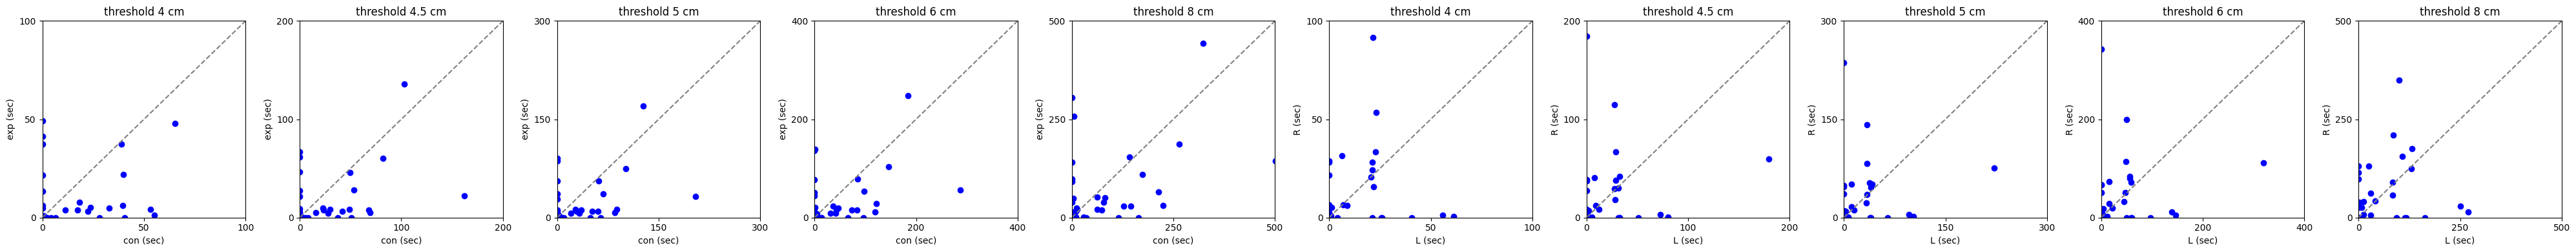

In [20]:
analysis_methods.update({"frequency_based_preference_index":False})
analysis_methods.update({"exclude_extreme_index":False})
trial_type_of_interest=[trial_type_list[2],trial_type_list[3]]
#trial_type_of_interest=[trial_type_list[0],trial_type_list[1]]
left_right_preference_across_animals,exp_con_preference_across_animals,_,_,_,_=calculate_preference_index(relative_pos_all_animals,trial_type_of_interest,analysis_methods,thresholds=[4,4.5,5,6,8])

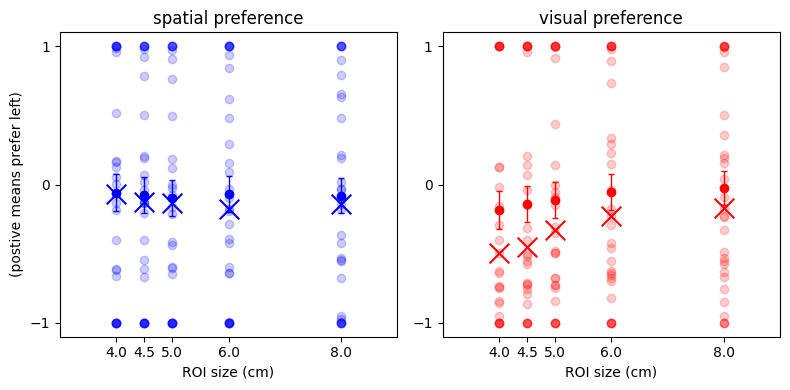

In [21]:
plot_preference_index(left_right_preference_across_animals,exp_con_preference_across_animals,trial_type_of_interest,analysis_methods,thresholds=[4,4.5,5,6,8])

assign epoch con is for LocustBand and epochs exp is for LocustBand_black


c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\preference_analysis.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if frequency_based_preference_index:
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\preference_analysis.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if frequency_based_preference_index:
c:\Users\neuroPC\Documents\GitHub\UnityDataAnalysis\preference_analysis.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

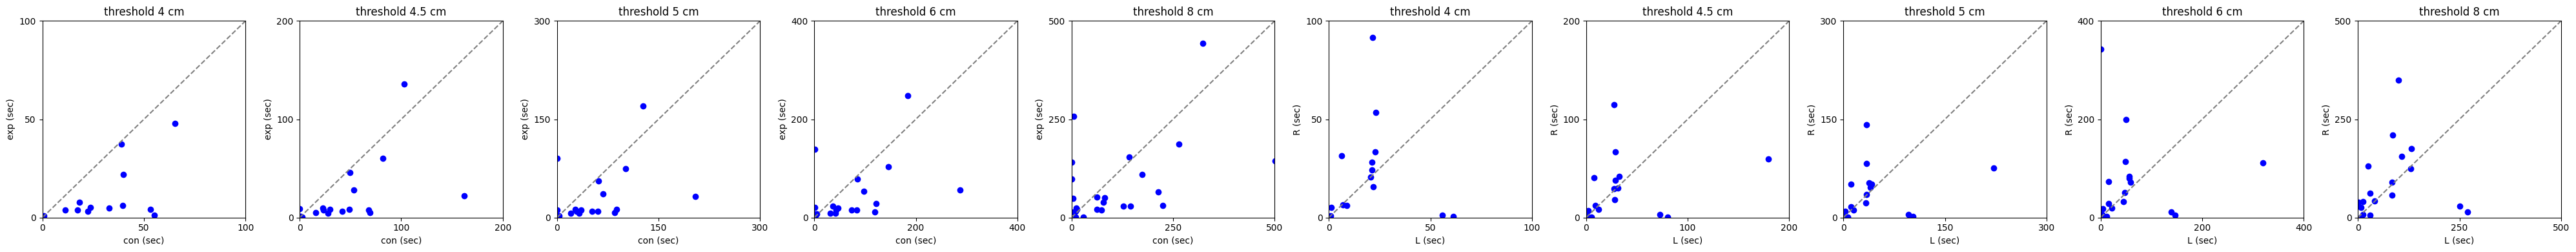

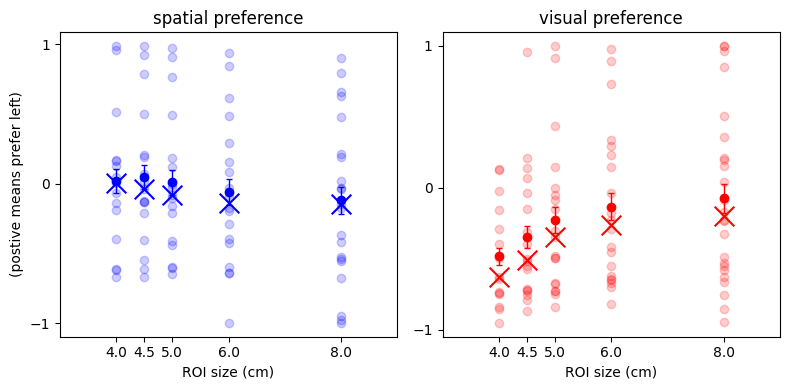

In [22]:
analysis_methods.update({"exclude_extreme_index":True})
left_right_preference_across_animals,exp_con_preference_across_animals,_,_,_,_=calculate_preference_index(relative_pos_all_animals,trial_type_of_interest,analysis_methods,thresholds=[4,4.5,5,6,8])
plot_preference_index(left_right_preference_across_animals,exp_con_preference_across_animals,trial_type_of_interest,analysis_methods,thresholds=[4,4.5,5,6,8])